In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import scipy.signal as signal
from scipy import sparse
from scipy.sparse.linalg import spsolve

In [35]:
def CAR(samples):
    s=[]
    for i in range(0, len(samples)):
        s.append((sum(samples))/64.0)
    
    sample=samples-s
    return sample, s

In [36]:
eeg=h5py.File('D:\Imprint-CMCL-Data\koushik\patient_id_6\Patient_id_06_Day90_04.01.2019\\aa_2019.01.04_13.16.04.hdf5',mode='r')
keys2= list(eeg.keys())
print keys2
keys1= list(eeg[keys2[0]].keys())
print keys1
#print eeg[keys2[0]][keys1[0]]
#eeg["RawData"]['Samples']
print list(eeg['RawData'].keys())
print eeg['RawData']['Samples'].shape[0]
sampletime = np.array(eeg['AsynchronData']["Time"])
time=sampletime/256.0
sampletime1=np.delete(sampletime, len(sampletime)-1)
#sampletime1=np.delete(sampletime1, len(sampletime1)-1)
#sampletime1=sampletime
sampletime1=np.delete(sampletime1, 0)
#sampletime1=np.delete(sampletime1, 0)
print sampletime
print sampletime1

[u'AsynchronData', u'RawData', u'SavedFeatues', u'Version']
[u'AsynchronSignalTypes', u'Time', u'TypeID', u'Value']
[u'AcquisitionTaskDescription', u'DAQDeviceCapabilities', u'DAQDeviceDescription', u'Samples', u'SessionDescription', u'SubjectDescription']
40655
[[ 9011]
 [40111]]
[]


In [37]:
def elliptic_bandpass(order, rp, rs, lowcut, highcut):
    fs=256
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.ellip(order, rp, rs, [low, high], btype='bandpass', analog=False, output='ba')
    return b, a

In [38]:
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    #D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [39]:
#from scipy.fftpack import fft, ifft
samples=np.array(eeg['RawData']['Samples'])
samples=samples.T
samples, _= CAR(samples)
for i in range(0, len(samples)):
    z=baseline_als(samples[i], 10**4, 0.1, 10)
    samples[i]=samples[i]-z
    

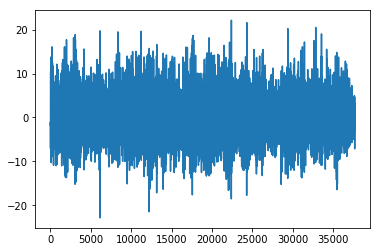

In [40]:
bsir=[]
fs=256
order=4
rp=0.5
rs=30
for i in range (0, len(samples)):
    b, a= elliptic_bandpass(order, rp, rs, 1, 25)
    bsir.append(signal.filtfilt(b, a, samples[i], padlen=0))
    
plt.plot(np.arange(len(bsir[13][3000:])), bsir[13][3000:])

In [41]:
bsi_channels=[[13, 31], [9, 27], [31, 49], [27, 45], [49, 59], [45, 57], [13, 33], [9, 25]]
bsi_channel_names=[['F4', 'C4'], ['F3', 'C3'], ['C4', 'P4'], ['C3', 'P3'], ['P4', 'O2'], ['P3', 'O1'], ['F4', 'T4'], 
                   ['F3', 'T3']]

In [42]:
def compute_bsi_t(bsir, t, T):
    ni=np.zeros(T)
    for i in range(0, len(bsi_channels)):
        
        rj=np.abs(np.fft.fft(bsir[bsi_channels[i][0]][t-T:t]))
        lj=np.abs(np.fft.fft(bsir[bsi_channels[i][1]][t-T:t]))
        ni=ni+((rj-lj)/(rj+lj))/len(bsi_channels)
        
        
    ni=np.mean(np.abs(ni))
    print (ni.real)
    return ni

In [47]:
T=256*20  #window time
bsi=[]
for i in range(sampletime[0]+T, sampletime[1], 1024):
    bsi.append(compute_bsi_t(bsir, i, T))
    #print i


0.2704173061395986
0.16677599419220188
0.05360035575974905
0.14754482108481826
0.05269658543241187
0.06436342955479105
0.0525078774444455
0.1317715739334407
0.10875682904299389
0.18838835888753058
0.0679040409290701
0.11892744872670624
0.12513873379433
0.11128270477678774
0.04010607331249128
0.05498703649443518
0.11336438042000907
0.11195475088166558
0.08177797974404473
0.13636053636601328
0.11794470909632775
0.074341090929718
0.20657650611935585
0.27869337153290985
0.05820558387423782
0.13004805866036856


[0.2704173061395986, 0.16677599419220188, 0.05360035575974905, 0.14754482108481826, 0.05269658543241187, 0.06436342955479105, 0.0525078774444455, 0.1317715739334407, 0.10875682904299389, 0.18838835888753058, 0.0679040409290701, 0.11892744872670624, 0.12513873379433, 0.11128270477678774, 0.04010607331249128, 0.05498703649443518, 0.11336438042000907, 0.11195475088166558, 0.08177797974404473, 0.13636053636601328, 0.11794470909632775, 0.074341090929718, 0.20657650611935585, 0.27869337153290985, 0.05820558387423782, 0.13004805866036856]


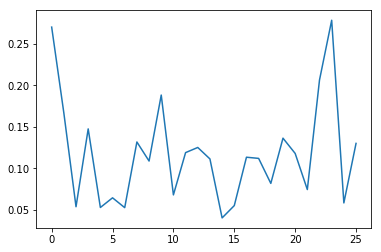

In [48]:
plt.plot(np.arange(len(bsi)), np.array(bsi))
print bsi

In [ ]:
t=16431
ni=np.zeros(T)

rj=bsir[bsi_channels[1][0]][t-T:t]
print rj
#z1=baseline_als(bsir[bsi_channels[1][1]][t-T:t],10**4, 0.01, 10)
lj=bsir[bsi_channels[1][1]][t-T:t]
ni=ni+((fft(rj)-fft(lj))/(fft(rj)+fft(lj)))
print max(ni.real)

In [ ]:
print len(bsi_channels)

In [ ]:
plt.plot(np.arange(len(rj)), rj)